In [1]:
import pandas as pd 
import numpy as np
import os 
import json
from math import ceil, floor

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,chi2

from sklearn.preprocessing import LabelEncoder,scale
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.utils.multiclass import unique_labels

from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 11})

import re
import nltk
from nltk.corpus import stopwords


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation, Conv1D, Dense, Embedding, Flatten, Input, Dropout, GlobalMaxPooling1D
from keras.metrics import categorical_accuracy
from keras.callbacks import  EarlyStopping


Using TensorFlow backend.


In [2]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;-]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
Number_RE = re.compile('[*^0-9]')
Bad_underline = re.compile('[*_*]')
RemoveTag = re.compile('&lt;|br&gt;|b&gt;|ul&gt;|li&gt;')

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = RemoveTag.sub('',text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = Number_RE.sub(' ', text) # replace Number symbols by space in text
    text = Bad_underline.sub(' ', text) # replace Underline symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
RemoveLastSpace = re.compile(' $')

def clean_text_category(text):
    text = RemoveLastSpace.sub('',text)
    return text
    

In [3]:
def classNumberThreshold(arr):
    dropCategory = []

    for key,value in arr.items():
        if(value<=30):
            dropCategory.append(key)
    return dropCategory

In [4]:
df = pd.read_csv('../walmartNewData.csv')

In [5]:
df = df[pd.notnull(df['longDescription'])]
df.longDescription = df.longDescription.apply(clean_text)
df = df[pd.notnull(df['itemId'])]


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117423 entries, 0 to 117597
Data columns (total 10 columns):
productName         117416 non-null object
shortDescription    117269 non-null object
longDescription     117423 non-null object
itemId              117423 non-null int64
category            117423 non-null int64
subcategory         117423 non-null int64
sub2category        117423 non-null int64
categoryName        117423 non-null object
subcategoryName     117423 non-null object
sub2categoryName    117423 non-null object
dtypes: int64(4), object(6)
memory usage: 9.9+ MB


In [7]:
le = LabelEncoder()
le.fit(df.category)
target = le.classes_
labels = le.transform(df.category)

le.fit(df.subcategory)
subtarget = le.classes_
sublabels = le.transform(df.subcategory)

In [8]:
targeName = [ np.unique(df[df['category']==ele]['categoryName'])[0] for ele in target]
subtargeName =  [ np.unique(df[df['subcategory']==ele]['subcategoryName'])[0] for ele in subtarget]

In [9]:
tfidfconverter = TfidfVectorizer(min_df=5, max_df=0.7)
X = tfidfconverter.fit_transform(df.longDescription)
featureNames = tfidfconverter.get_feature_names()

In [10]:
X_train, X_test, y_train_info, y_test_info = train_test_split(X, pd.DataFrame({'index':df.index, 'label':labels}), 
                                                    test_size=0.1, random_state = 27)

In [11]:
y_train = y_train_info.label
y_test = y_test_info.label


In [12]:
model = LinearSVC(random_state=42,class_weight="balanced")
model.fit(X_train,y_train)

/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [13]:

classWithInfluence = {}

coef = model.coef_
coef = scale(coef)

coefTotalSize = coef.shape[0]*coef.shape[1]
coef1DArr = coef.reshape(coefTotalSize,1)
Max = ceil(max(coef1DArr[0]))
Min = floor(min(coef1DArr[0]))

for index in range(0,len(coef)):
    normalisedCoef = [round((ele-Min)/(Max-Min),2) for ele in coef[index]]
    name = featureNames
    classWithInfluence[targeName[index]] = list(zip(name,normalisedCoef))
            
Top10InflunceFeature = {}
for key, value in classWithInfluence.items():
    Top10InflunceFeature[key] = sorted(value, key=lambda x: x[1], reverse=True)[:10]

with open('Walmart/CompanyTopFeatureByClass.json', 'w') as json_file:
    json.dump(Top10InflunceFeature, json_file, indent=2)    

In [14]:
selectBest = SelectKBest(chi2, k= len(target)*10).fit(X_train, y_train)

originScore = selectBest.scores_
supportsList = selectBest.get_support()
Max = ceil(max(originScore))
Min = floor(min(originScore))
Normscores = [round((ele-Min)/(Max-Min),2) for ele in originScore]
scoreDict = dict(zip(featureNames,
                     list(zip(supportsList, Normscores))))
newScoreDict = {}

for key , item in scoreDict.items():
    if(item[0]):
        newScoreDict[key] = item[1]

ranksfeaturesDict = pd.DataFrame({"Feature":list(newScoreDict.keys()),
                                  "Score":list(newScoreDict.values())},dtype=np.int64)
ranksfeaturesDict = ranksfeaturesDict.sort_values(by=['Score'],ascending=False)
ranksfeaturesDict.to_csv("Walmart/RankByTotalFeatureWalmart.csv",index=False,compression=None)

In [15]:
BestSize  = [ele for ele in range(100, len(featureNames), 100) ]
Models = []
Scores = []
SelectModels  = []
for ele in range(100, len(featureNames), 100):
    print("--- Best "+ str(ele) + " features \n")
    selectBest = SelectKBest(chi2, k= ele)
    model = LinearSVC(random_state=42,class_weight="balanced")
    K_best_linearsvc = Pipeline([('SelectBest', selectBest), ('linearSVC', model)])
    K_best_linearsvc.fit(X_train,y_train)
    score = K_best_linearsvc.score(X_test,y_test)
    Models.append(K_best_linearsvc)
    Scores.append(score)

bestModel = Models[np.argmax(Scores)]
bestSize = BestSize[np.argmax(Scores)]

# save the model to disk
filename = 'Walmart/'+str(bestSize)+'BestLinearSVC.sav'
joblib.dump(bestModel, filename)



yConfidence = bestModel.decision_function(X_test)

yPred = bestModel.predict(X_test)


--- Best 100 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 200 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 300 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 400 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 500 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 600 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 700 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 800 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 900 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 1000 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 1100 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 1200 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 1300 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 1400 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 1500 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 1600 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 1700 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 1800 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 1900 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 2000 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 2100 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 2200 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 2300 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 2400 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 2500 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 2600 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 2700 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 2800 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 2900 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 3000 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 3100 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 3200 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 3300 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 3400 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 3500 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 3600 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 3700 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 3800 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 3900 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 4000 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 4100 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 4200 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 4300 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 4400 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 4500 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 4600 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 4700 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 4800 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 4900 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 5000 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 5100 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 5200 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 5300 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 5400 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 5500 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 5600 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 5700 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 5800 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 5900 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 6000 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 6100 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 6200 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 6300 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 6400 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 6500 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 6600 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 6700 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 6800 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 6900 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 7000 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 7100 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 7200 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 7300 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 7400 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 7500 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 7600 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 7700 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 7800 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 7900 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 8000 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 8100 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 8200 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 8300 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 8400 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 8500 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 8600 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 8700 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 8800 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 8900 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 9000 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 9100 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 9200 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 9300 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 9400 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 9500 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 9600 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 9700 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 9800 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 9900 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 10000 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 10100 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 10200 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 10300 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 10400 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 10500 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 10600 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 10700 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 10800 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 10900 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 11000 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 11100 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 11200 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 11300 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 11400 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 11500 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 11600 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 11700 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 11800 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 11900 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 12000 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 12100 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 12200 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 12300 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 12400 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 12500 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 12600 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 12700 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 12800 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 12900 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 13000 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 13100 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 13200 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 13300 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 13400 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 13500 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 13600 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 13700 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 13800 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 13900 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 14000 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 14100 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 14200 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 14300 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 14400 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 14500 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 14600 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 14700 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 14800 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 14900 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 15000 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 15100 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 15200 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 15300 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 15400 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 15500 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 15600 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 15700 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 15800 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 15900 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 16000 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 16100 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 16200 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 16300 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 16400 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 16500 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 16600 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 16700 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 16800 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 16900 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 17000 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 17100 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 17200 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 17300 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 17400 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 17500 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 17600 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 17700 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 17800 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 17900 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 18000 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 18100 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 18200 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 18300 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 18400 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 18500 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 18600 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 18700 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 18800 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 18900 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 19000 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 19100 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 19200 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 19300 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 19400 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 19500 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 19600 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 19700 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 19800 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 19900 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 20000 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 20100 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 20200 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 20300 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 20400 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 20500 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 20600 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 20700 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 20800 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 20900 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 21000 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 21100 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 21200 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 21300 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 21400 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 21500 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 21600 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 21700 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 21800 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 21900 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 22000 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 22100 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 22200 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 22300 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 22400 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 22500 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 22600 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 22700 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 22800 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 22900 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 23000 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 23100 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 23200 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 23300 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 23400 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 23500 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 23600 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 23700 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 23800 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 23900 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 24000 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 24100 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 24200 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 24300 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 24400 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 24500 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 24600 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 24700 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 24800 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 24900 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 25000 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 25100 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 25200 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 25300 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 25400 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 25500 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 25600 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 25700 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 25800 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 25900 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 26000 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 26100 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 26200 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 26300 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 26400 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 26500 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 26600 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 26700 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 26800 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 26900 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 27000 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 27100 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 27200 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 27300 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 27400 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 27500 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 27600 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--- Best 27700 features 



/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [16]:
totalConfidenceSize = yConfidence.shape[0]*yConfidence.shape[1]
Confidence1DArr = yConfidence.reshape(totalConfidenceSize,1)
Max = ceil(max(Confidence1DArr)[0])
Min = floor(min(Confidence1DArr)[0])
NormalisedConfid = [round((max(ele)-Min)/(Max-Min),2) for ele in yConfidence]
productID = [ df[df.index==ele]['itemId'].values[0] for ele in y_test_info['index'] ]
ProductDescription =[ df[df.index==ele]['longDescription'].values[0] for ele in y_test_info['index'] ]
LinearSVCResult = pd.DataFrame({'id':productID,'description':ProductDescription,
                         'trueClass': y_test,'trueClassNaem':[targeName[e] for e in y_test] ,
                         'predictClass':yPred,'predictClassName':[targeName[e] for e in yPred],
                         'Confidence':NormalisedConfid})
LinearSVCResult.to_csv("Walmart/SVCResults.csv",index=False,compression=None)

In [17]:
def draw_confidenceReport(data):
    num = [ ele*0.01 for ele in range(20,81,2)]
    totalitems = []
    correct = []
    incorrect = []
    for ele in num:
        Threshold = data[data.Confidence>ele]
        correct.append(len(Threshold[Threshold['trueClass']==Threshold['predictClass']].index))
        incorrect.append(len(Threshold[Threshold['trueClass']!=Threshold['predictClass']].index))
        totalitems.append(len(Threshold.index))
    
    ClassfiedProportion = [ ele/len(data.index) for ele in totalitems]
    
    Acc =[]
    for ele in zip(correct,totalitems):
        if (ele[1]==0):
            Acc.append(0)
        else:
            Acc.append(ele[0]/ele[1])

    fig,ax  = plt.subplots()
    
    color = 'tab:blue'
    ax.scatter(num,ClassfiedProportion,label="Proportion classified",color=color)
    ax.set_xlabel("Confidence Score")
    ax.set_ylabel("Proportion classified", color=color)
    ax.xaxis.set_ticks(np.arange(0,1.1,0.1))
    ax.yaxis.set_ticks(np.arange(0,1.1,0.1))
    ax.tick_params(axis='y', labelcolor=color)

    color = 'tab:red'

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.scatter(num,Acc,label="Accuracy", color=color)
    ax2.set_ylabel("Accuracy", color=color)
    ax2.yaxis.set_ticks(np.arange(0,1.1,0.1))
    ax2.tick_params(axis='y', labelcolor=color)

    ax.grid()
    fig.savefig("Walmart/ConfidenceScoreReportSVC.png")

In [18]:
print(classification_report(y_test, yPred,target_names=targeName))
with open('Walmart/SVCReport.txt', 'w') as file:
    file.write(classification_report(y_test, yPred,target_names=targeName))

                         precision    recall  f1-score   support

            Video Games       0.69      0.88      0.78        57
      Party & Occasions       0.65      0.76      0.70       126
                Jewelry       0.97      0.97      0.97      1195
                  Books       0.90      0.95      0.92      1031
            Electronics       0.87      0.91      0.89       540
                   Home       0.96      0.91      0.93      3006
      Movies & TV Shows       0.89      1.00      0.94        17
                  Music       0.36      0.45      0.40        29
      Sports & Outdoors       0.71      0.77      0.74       269
                   Toys       0.69      0.75      0.72       185
                   Baby       0.78      0.70      0.74        20
         Patio & Garden       0.58      0.72      0.64       117
               Clothing       0.96      0.95      0.95      2272
                   Pets       0.84      0.90      0.87        63
                Feature 

/Users/apple/Desktop/projects/uob-msc50-project/classification/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:
cm = confusion_matrix(y_test, yPred)

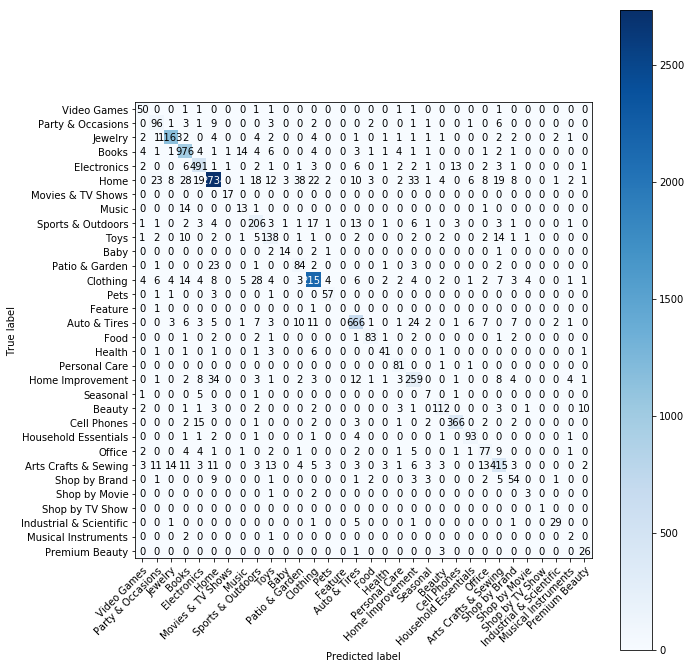

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
im =ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
classes = targeName
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,ylabel='True label',xlabel='Predicted label')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
fig.savefig("Walmart/LinearSVCConfusionMatrix.png")

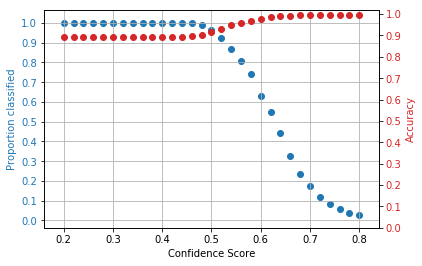

In [21]:
draw_confidenceReport(LinearSVCResult)

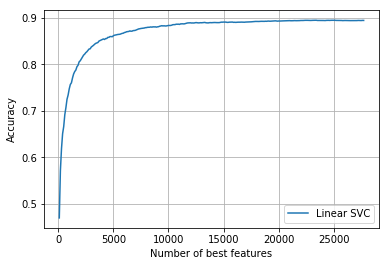

In [22]:
fig,ax  = plt.subplots()
ax.plot(BestSize,Scores,label="Linear SVC")
ax.set_xlabel("Number of best features")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.savefig("Walmart/linearsvcbestFeatureSize.png")